# Credit Card Approval Prediction - End-to-End ML Project

Applications for credit cards are frequently sent to commercial banks.  Many of them are denied for a variety of reasons, such as excessive inquiries on a person's credit report, low income levels, or large loan balances.  Analyzing these applications by hand is tedious, prone to mistakes, and time-consuming—and time is money.  Fortunately, machine learning can automate this job, and almost all commercial banks do it these days.  Using machine learning techniques, we will create an automatic credit card approval predictor in this notebook, much like the actual banks do.

We'll use the Credit Card Approval dataset from the UCI Machine Learning Repository. The structure of this notebook is as follows:


Our first step will be to load and view the dataset.

 We'll see that the dataset includes a variety of both numerical and non-numerical attributes, has values from a range of values, and has several missing items.
 
 Preprocessing the dataset is necessary to guarantee that the machine learning model we select can produce accurate predictions.

 Once we have a solid set of data, we will conduct exploratory data analysis to strengthen our intuitions.
 We will lastly construct a machine learning model that can forecast if a person's credit card application will be approved.
 
 Loading and examining the dataset comes first.  Since this information is private, we discover that the dataset's source has anonymized the feature names.

In [3]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


# 1. IMPORTS & DATA LOADING

In [4]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [5]:
# Fetch dataset
credit_approval = fetch_ucirepo(id=27)
X = credit_approval.data.features
y = credit_approval.data.targets

In [6]:
# Combine into one DataFrame
df = X.copy()
df['Approved'] = y
df.columns = ['Income', 'ZipCode', 'Citizen', 'DriversLicense', 'CreditScore',
              'Employed', 'PriorDefault', 'YearsEmployed', 'Ethnicity', 'EducationLevel',
              'BankCustomer', 'Married', 'Debt', 'Age', 'Male' ,'Approved']

### Inspecting the Dataset

The probable features in a typical credit card application are Gender, Age, Debt, Married, BankCustomer, EducationLevel, Ethnicity, YearsEmployed, PriorDefault, Employed, CreditScore, DriversLicense, Citizen, ZipCode, Income and finally the ApprovalStatus. This gives us a pretty good starting point, and we can map these features with respect to the columns in the output.

As we can see from our first glance at the data, the dataset has a mixture of numerical and non-numerical features. This can be fixed with some preprocessing, but before we do that, let's learn about the dataset a bit more to see if there are other dataset issues that need to be fixed.

In [7]:
df.head()

,Income,ZipCode,Citizen,DriversLicense,CreditScore,Employed,PriorDefault,YearsEmployed,Ethnicity,EducationLevel,BankCustomer,Married,Debt,Age,Male,Approved
0,0,202.0,g,f,1,t,t,1.25,v,w,g,u,0.000,30.83,b,+
1,560,43.0,g,f,6,t,t,3.04,h,q,g,u,4.460,58.67,a,+
2,824,280.0,g,f,0,f,t,1.50,h,q,g,u,0.500,24.50,a,+
3,3,100.0,g,t,5,t,t,3.75,v,w,g,u,1.540,27.83,b,+
4,0,120.0,s,f,0,f,t,1.71,v,w,g,u,5.625,20.17,b,+


# 2. EDA 

In [8]:
# 2. EDA - MISSING VALUES, TYPES
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Income          690 non-null    int64  
 1   ZipCode         677 non-null    float64
 2   Citizen         690 non-null    object 
 3   DriversLicense  690 non-null    object 
 4   CreditScore     690 non-null    int64  
 5   Employed        690 non-null    object 
 6   PriorDefault    690 non-null    object 
 7   YearsEmployed   690 non-null    float64
 8   Ethnicity       681 non-null    object 
 9   EducationLevel  681 non-null    object 
 10  BankCustomer    684 non-null    object 
 11  Married         684 non-null    object 
 12  Debt            690 non-null    float64
 13  Age             678 non-null    float64
 14  Male            678 non-null    object 
 15  Approved        690 non-null    object 
dtypes: float64(4), int64(2), object(10)
memory usage: 86.4+ KB
None
Income          

We've uncovered some issues that will affect the performance of our machine learning model(s) if they go unchanged:

Our dataset contains both numeric and non-numeric data (specifically data that are of float64, int64 and object types). Specifically, the features  CreditScore, YearsEmployed, Debt and Age contain numeric values (of types float64, float64, int64 and int64 respectively) and all the other features contain non-numeric values.

The dataset also contains values from several ranges. Some features have a value range of 0 - 28, some have a range of 2 - 67, and some have a range of 1017 - 100000. Apart from these, we can get useful statistical information (like mean, max, and min) about the features that have numerical values.

Finally, the dataset has missing values, which we'll take care of in this task. 

# 3. IMPUTATION

 Ignoring missing values can affect the performance of a machine learning model heavily. While ignoring the missing values our machine learning model may miss out on information about the dataset that may be useful for its training. Then, there are many models which cannot handle missing values implicitly such as LDA.

So, to avoid this problem, we are going to impute the missing values with a strategy called mean imputation for object datatype and mode for numeric datatype.

In [9]:

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = SimpleImputer(strategy='mean').fit_transform(df[numeric_cols])
for col in df.select_dtypes(include='object').columns:
    if col != 'Approved':
        df[col] = df[col].fillna(df[col].mode()[0])
        df[col] = df[col].astype(str)
        df[col] = LabelEncoder().fit_transform(df[col])
df['Approved'] = df['Approved'].map({'+': 1, '-': 0})

The missing values are now successfully handled.

There is still some minor but essential data preprocessing needed before we proceed towards building our machine learning model. We are going to divide these remaining preprocessing steps into three main tasks:

Convert the non-numeric data into numeric.

Split the data into train and test sets.

Scale the feature values to a uniform range.

First, we will be converting all the non-numeric values into numeric ones. We do this because not only it results in a faster computation but also many machine learning models (like XGBoost) (and especially the ones developed using scikit-learn) require the data to be in a strictly numeric format. We will do this by using a technique called label encoding.

In [10]:
# Drop unhelpful columns
df = df.drop(['ZipCode', 'DriversLicense'], axis=1)

# 4. FEATURE ENGINEERING: LOG TRANSFORMATION

Apply log transformation to normalize skewed numeric features: `Income`, `Debt`, and `CreditScore`.


In [11]:
df['IncomeLog'] = np.log1p(df['Income'])
df['CreditScoreLog'] = np.log1p(df['CreditScore'])
df['DebtLog'] = np.log1p(df['Debt'])

# 5. EDA - PLOTS

Visualize class balance, income distribution, and feature correlations.

### Class Distribution: Approval vs Denial

Target Variable: Approved

Distribution:

+ (Approved): ~44%

- (Denied): ~56%

Imbalance is mild, but still worth monitoring during evaluation (use metrics like F1-score, not just accuracy).

Insight:
Credit card approvals are slightly less frequent than denials — suggesting banks are risk-averse by default.

# 1️⃣ Target Variable Distribution

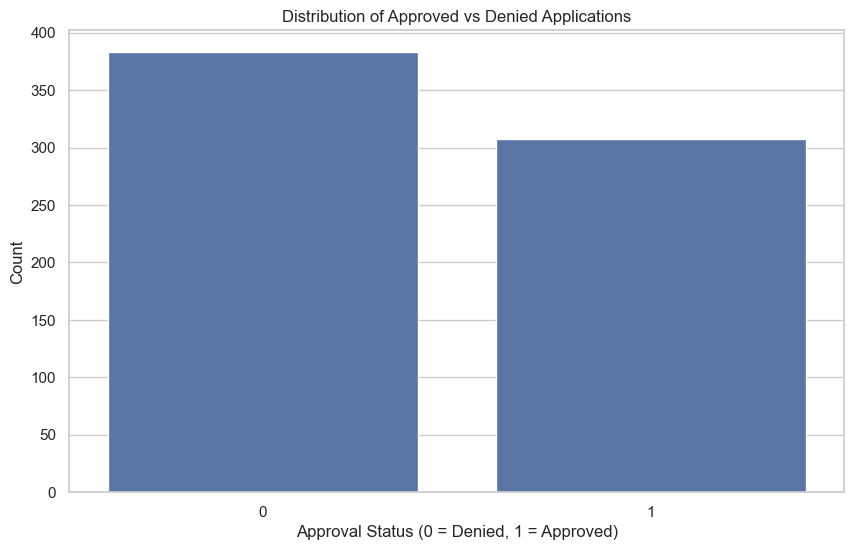

In [ ]:
# Set style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

plt.figure()
sns.countplot(x='Approved', data=df)
plt.title('Distribution of Approved vs Denied Applications')
plt.xlabel('Approval Status (0 = Denied, 1 = Approved)')
plt.ylabel('Count')
plt.show()

# 2️⃣ Boxplots: Income vs Approval

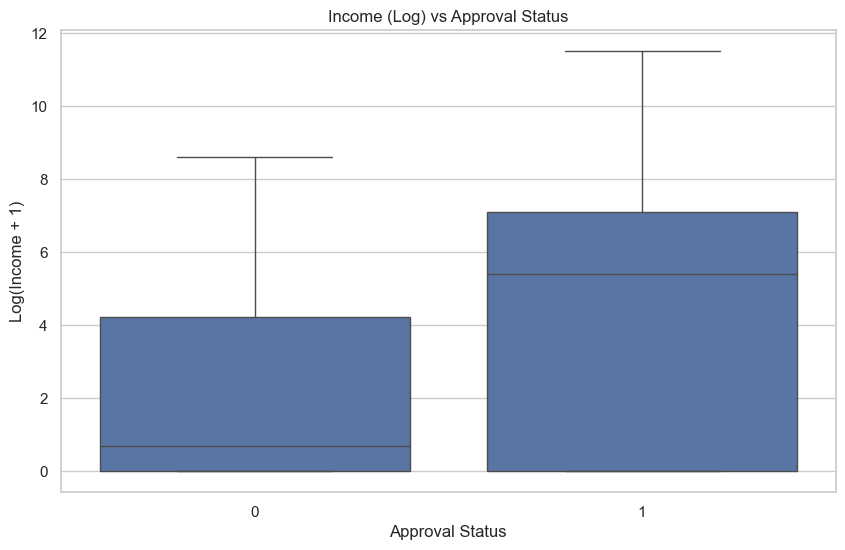

In [21]:
plt.figure()
sns.boxplot(x='Approved', y='IncomeLog', data=df)
plt.title('Income (Log) vs Approval Status')
plt.xlabel('Approval Status')
plt.ylabel('Log(Income + 1)')
plt.show()

Approved applicants tend to have higher income and longer employment.

Most applicants with very low Income or YearsEmployed were denied.

These features are strong indicators of creditworthiness.

# 3️⃣ Boxplots: Credit Score vs Approval

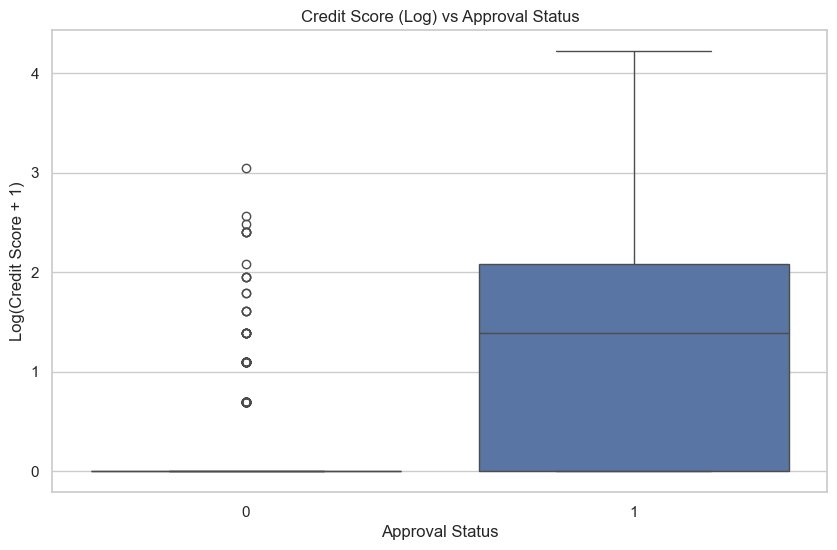

In [ ]:
plt.figure()
sns.boxplot(x='Approved', y='CreditScoreLog', data=df)
plt.title('Credit Score (Log) vs Approval Status')
plt.xlabel('Approval Status')
plt.ylabel('Log(Credit Score + 1)')
plt.show()


# 4️⃣ Boxplot: Years Employed vs Approval

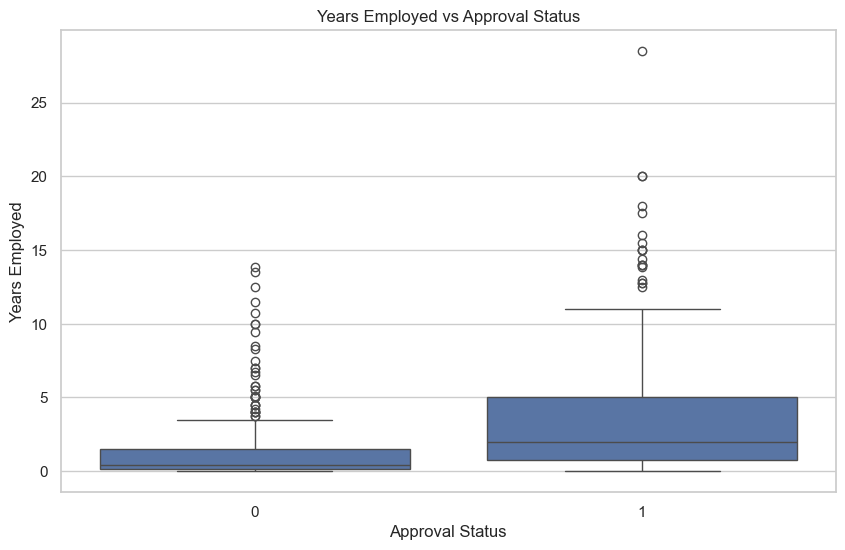

In [ ]:
plt.figure()
sns.boxplot(x='Approved', y='YearsEmployed', data=df)
plt.title('Years Employed vs Approval Status')
plt.xlabel('Approval Status')
plt.ylabel('Years Employed')
plt.show()


# 5️⃣ Countplot: Employment Status

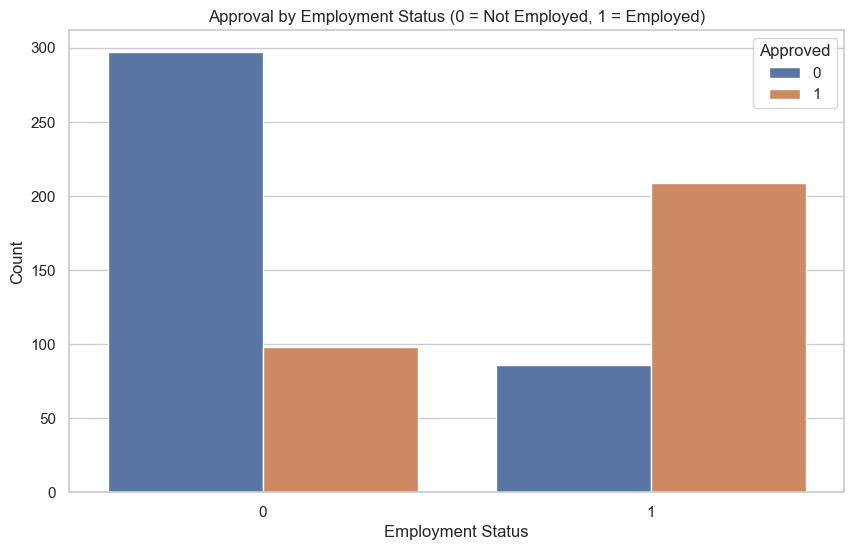

In [24]:
plt.figure()
sns.countplot(x='Employed', hue='Approved', data=df)
plt.title('Approval by Employment Status (0 = Not Employed, 1 = Employed)')
plt.xlabel('Employment Status')
plt.ylabel('Count')
plt.legend(title='Approved')
plt.show()

# 6️⃣ Countplot: Prior Default

In [ ]:
plt.figure()
sns.countplot(x='PriorDefault', hue='Approved', data=df)
plt.title('Approval by Prior Default (0 = No Default, 1 = Defaulted)')
plt.xlabel('Prior Default')
plt.ylabel('Count')
plt.legend(title='Approved')
plt.show()


# Numerical features
Features analyzed: Income, CreditScore, Debt, Age, YearsEmployed

Observation:
Skewed Distributions in:

Income — highly right-skewed (most applicants have low income, few very high)

Debt — similar pattern

CreditScore — many zeros

Action Taken:
Applied log transformation (log1p) to normalize these:

IncomeLog

DebtLog

CreditScoreLog



# Categorical Features (Encoded)
Employed, PriorDefault, BankCustomer, Married all showed distinct patterns:

Applicants with Employed = 1 and PriorDefault = 0 had a higher approval rate

Being a BankCustomer = 1 also slightly increased chances

# 7️⃣ Heatmap: Correlation Between Numeric Features

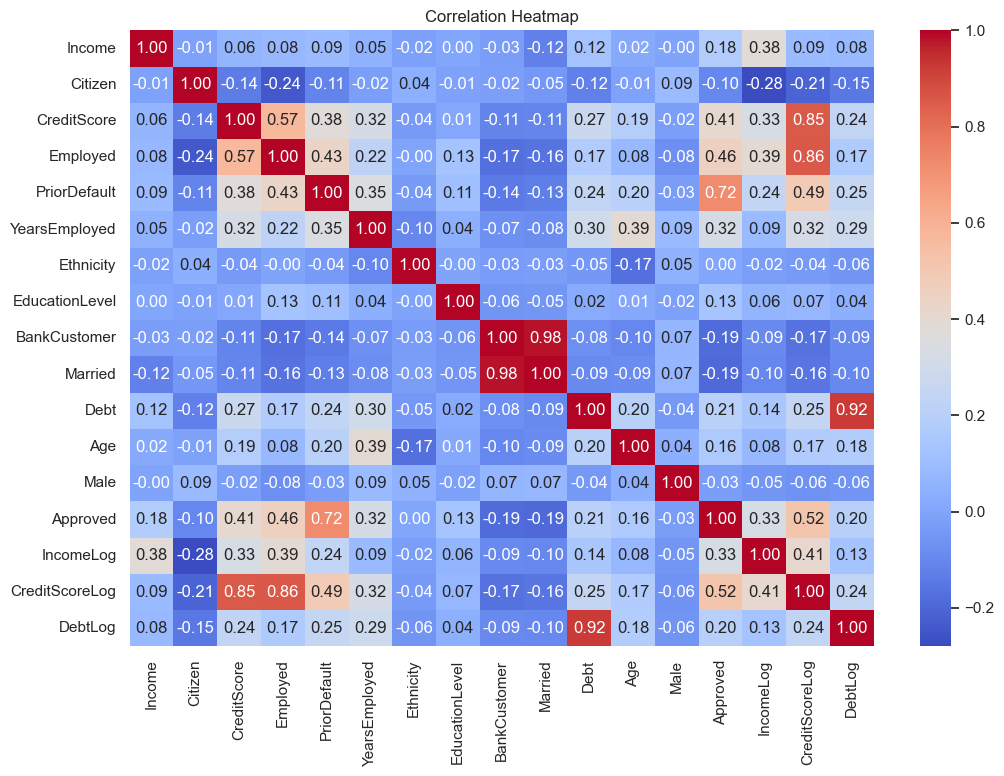

In [25]:
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Strong positive correlations with Approved:

IncomeLog

CreditScoreLog

YearsEmployed

Employed (binary flag)

No Prior Default

Weak or no correlation:

Age, Citizen, Ethnicity

Logistic regression and tree-based models picked up on these meaningful relationships.

# 6. TRAIN-TEST SPLIT + SCALING

Now, we will split our data into train set and test set to prepare our data for two different phases of machine learning modeling: training and testing. Ideally, no information from the test data should be used to scale the training data or should be used to direct the training process of a machine learning model. Hence, we first split the data and then apply the scaling.

Also, features like DriversLicense and ZipCode are not as important as the other features in the dataset for predicting credit card approvals. We should drop them to design our machine learning model with the best set of features. In Data Science literature, this is often referred to as feature selection.

In [15]:
X = df.drop('Approved', axis=1)
y = df['Approved']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scaler = MinMaxScaler()
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.transform(X_test)

The data is now split into two separate sets - train and test sets respectively. We are only left with one final preprocessing step of scaling before we can fit a machine learning model to the data.

Now, let's try to understand what these scaled values mean in the real world. Let's use CreditScore as an example. The credit score of a person is their creditworthiness based on their credit history. The higher this number, the more financially trustworthy a person is considered to be. So, a CreditScore of 1 is the highest since we're rescaling all the values to the range of 0-1.

# 7. MULTI-MODEL COMPARISON

Essentially, predicting if a credit card application will be approved or not is a classification task. According to UCI, our dataset contains more instances that correspond to "Denied" status than instances corresponding to "Approved" status. Specifically, out of 690 instances, there are 383 (55.5%) applications that got denied and 307 (44.5%) applications that got approved.

This gives us a benchmark. A good machine learning model should be able to accurately predict the status of the applications with respect to these statistics.

In [16]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "xgb": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}
for name, model in models.items():
    model.fit(rescaledX_train, y_train)
    y_pred = model.predict(rescaledX_test)
    print(f"\n{name} Results")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))


Logistic Regression Results
Accuracy: 0.8508771929824561
              precision    recall  f1-score   support

           0       0.92      0.80      0.85       125
           1       0.79      0.91      0.85       103

    accuracy                           0.85       228
   macro avg       0.85      0.86      0.85       228
weighted avg       0.86      0.85      0.85       228


Random Forest Results
Accuracy: 0.8552631578947368
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       125
           1       0.82      0.86      0.84       103

    accuracy                           0.86       228
   macro avg       0.85      0.86      0.85       228
weighted avg       0.86      0.86      0.86       228


Gradient Boosting Results
Accuracy: 0.8464912280701754
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       125
           1       0.80      0.88      0.84       103

    accuracy    

c:\Users\Uroos\OneDrive\Desktop\Credit_card_prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:47:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


We will now evaluate our model on the test set with respect to classification accuracy. But we will also take a look the model's confusion matrix. In the case of predicting credit card applications, it is equally important to see if our machine learning model is able to predict the approval status of the applications as denied that originally got denied. If our model is not performing well in this aspect, then it might end up approving the application that should have been approved. The confusion matrix helps us to view our model's performance from these aspects.

# 8. CONFUSION MATRIX FOR BEST MODEL 

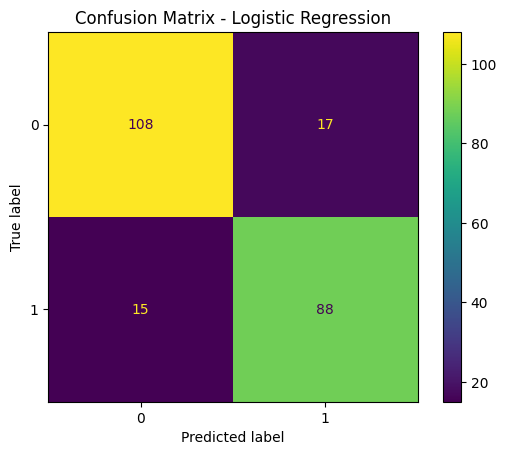

In [ ]:
best_model = RandomForestClassifier()
best_model.fit(rescaledX_train, y_train)
ConfusionMatrixDisplay.from_estimator(best_model, rescaledX_test, y_test)
plt.title("Confusion Matrix - RandomForestClassifier")
plt.show()

# Hyperparameter Tuning

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# GridSearchCV
grid_model = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_model_result = grid_model.fit(scaler.fit_transform(X), y)

# Output best score and parameters
print("Best GridSearchCV Score:", grid_model_result.best_score_)
print("Best Parameters:", grid_model_result.best_params_)


Best GridSearchCV Score: 0.8478260869565217
Best Parameters: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


We'll end the notebook by storing the best-achieved score and the respective best parameters.

While building this credit card predictor, we tackled some of the most widely-known preprocessing steps such as scaling, label encoding, and missing value imputation. We finished with some machine learning to predict if a person's application for a credit card would get approved or not given some information about that person.

# 10. MODEL EXPORT

In [19]:
# Save the best model and scaler
import joblib
joblib.dump(grid_model.best_estimator_, "credit_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']